# Optimization with JuMP

Optimization models play a central role in operations research. 

In this session, we will explore the basic functionalities of JuMP, a modeling language to define and solve optimization models in Julia.

## Sudoku

![Sudoku](http://upload.wikimedia.org/wikipedia/commons/f/ff/Sudoku-by-L2G-20050714.svg)

**Sudoku** is a number puzzle played on a 9x9 grid. The challenge is to place a digit between 1 and 9 inclusive in each empty cell, such that the completed grid obeys the following rules:

* Each row contains the numbers 1 to 9 once and only once.
* Each column contains the numbers 1 to 9 once and only once.
* Each 3x3 subgrid contains the numbers 1 to 9 once and only once.

Goal: Model the Sudoku problem as an optimization problem. Write a Julia function to solve it.

**Variables**

We define binary variables 
$$ x_{i,j,k} \in \{0, 1\}, $$
for each row $i$, column $j$ and integer $k \in \{ 1,2, \dots,9\}$.

$x_{i,j,k} = 1$ iff the number $k$ appears in cell $(i,j)$

**Constraints**

- Exactly one value appears in each cell: for all $(i,j)$,
$$\sum_{k=1}^9 x_{i,j,k} = 1$$
- Each value appears in each row exactly once: for all $i$, all $k$,
$$\sum_{j=1}^9 x_{i,j,k} = 1$$
- Each value appears in each column exactly once: for all $j$, all $k$,
$$\sum_{i=1}^9 x_{i,j,k} = 1$$
- Each value appears in each 3x3 subgrid exactly once: for all subgrid $(i,j) \in \{1,4,7\}\times\{1,4,7\}$, for all $k$,
$$\sum_{i'=i}^{i+2} \sum_{j'=j}^{j+2} x_{i,j,k} = 1$$
- Match the value on known cells 

**Objective?**

Let us solve this problem in Julia now!

In [1]:
init_vals = [
5 3 0 0 7 0 0 0 0
6 0 0 1 9 5 0 0 0
0 9 8 0 0 0 0 6 0
8 0 0 0 6 0 0 0 3
4 0 0 8 0 3 0 0 1
7 0 0 0 2 0 0 0 6
0 6 0 0 0 0 2 8 0
0 0 0 4 1 9 0 0 5
0 0 0 0 8 0 0 7 9
]

9×9 Matrix{Int64}:
 5  3  0  0  7  0  0  0  0
 6  0  0  1  9  5  0  0  0
 0  9  8  0  0  0  0  6  0
 8  0  0  0  6  0  0  0  3
 4  0  0  8  0  3  0  0  1
 7  0  0  0  2  0  0  0  6
 0  6  0  0  0  0  2  8  0
 0  0  0  4  1  9  0  0  5
 0  0  0  0  8  0  0  7  9

First, we'll write a basic helper function that will plot the sudoku for us.

In [2]:
using PyPlot
# Displays a sudoku matrix. If an initial state is provided, 
# then the new numbers are displayed in red. 
function display_sudoku(sudoku, initial_state=zeros(9,9))
    fig, ax = subplots()
    ax[:axis]("off")
    # Make sudoku basic 9x9 grid.
    for i in 0:9
        plot([i,i], [0, 9], color = "black")
        plot([0, 9], [i,i], color = "black")
    end
    # Make thicker lines to separate the 3x3 subgrids.
    for i in 0:3:9
        plot([i,i], [0,9], color = "black", linewidth = 3)
        plot([0,9], [i,i], color = "black", linewidth = 3)
    end
    # Display the values at the right square.
    for i in 0:8
        for j in 0:8 
            value = Int(sudoku[9-j,i+1])
            old_value = initial_state[9-j,i+1]
            # If an initial state is not provided (set to zero) or the value of the 
            # square did not change, the color is set to black. Otherwise, it becomes red.
            col = (sum(initial_state) == 0 || old_value == value) ? "black" : "red"
            if value > 0 # Omit zero values  
                text(i + 0.35, j + 0.33, value, size = 16, color = col)
            end
        end
    end
end

display_sudoku (generic function with 2 methods)

Let's test it out!

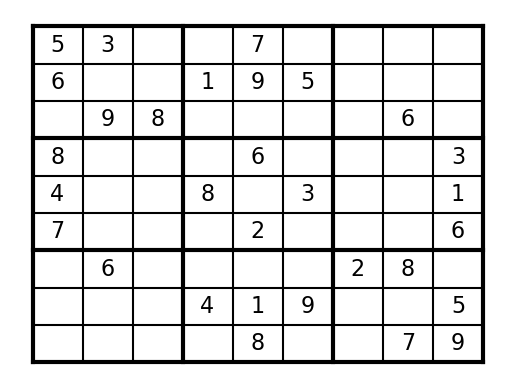

In [3]:
display_sudoku(init_vals)

#### JuMP Formulation
Now, translate the constraints that we wrote above into a JuMP formulation. We have started the model below.

In [4]:
using Gurobi, JuMP
sudoku = Model(with_optimizer(Gurobi.Optimizer))

@variable(sudoku, x[i=1:9, j=1:9, k=1:9], Bin)

# Exactly one value appears in each cell
@constraint(sudoku, [i=1:9, j=1:9], sum([x[i,j,k] for k in 1:9]) == 1) #constraints indexed by their indices

# Each value appears in each row exactly once.

# Each value appears in each column exactly once.

# Each value appears in each 3x3 subgrid exactly once.

# Fix given values. 



Academic license - for non-commercial use only - expires 2022-08-14


In [5]:
optimize!(sudoku)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 354 rows, 729 columns and 2946 nonzeros
Model fingerprint: 0x1c2863e1
Variable types: 0 continuous, 729 integer (729 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 354 rows and 729 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

User-callback calls 38, time in user-callback 0.00 sec


In [6]:
sol = sum(k * value.(x)[:,:,k] for k in 1:9)

9×9 Matrix{Float64}:
 5.0  3.0  4.0  6.0  7.0  8.0  9.0  1.0  2.0
 6.0  7.0  2.0  1.0  9.0  5.0  3.0  4.0  8.0
 1.0  9.0  8.0  3.0  4.0  2.0  5.0  6.0  7.0
 8.0  5.0  9.0  7.0  6.0  1.0  4.0  2.0  3.0
 4.0  2.0  6.0  8.0  5.0  3.0  7.0  9.0  1.0
 7.0  1.0  3.0  9.0  2.0  4.0  8.0  5.0  6.0
 9.0  6.0  1.0  5.0  3.0  7.0  2.0  8.0  4.0
 2.0  8.0  7.0  4.0  1.0  9.0  6.0  3.0  5.0
 3.0  4.0  5.0  2.0  8.0  6.0  1.0  7.0  9.0

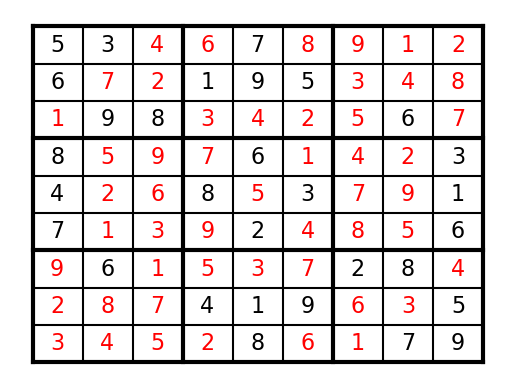

In [7]:
display_sudoku(sol, init_vals)